## Nutrient Demands



### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [1]:
%pip install -r requirements.txt

  Using cached CFEDemands-0.6.1-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached dvc-3.59.1-py3-none-any.whl.metadata (18 kB)
  Using cached ray-2.44.1-cp311-cp311-manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached celery-5.5.1-py3-none-any.whl.metadata (22 kB)
  Using cached configobj-5.0.9-py2.py3-none-any.whl.metadata (3.2 kB)
  Using cached dpath-2.2.0-py3-none-any.whl.metadata (15 kB)
  Using cached dulwich-0.22.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached dvc_data-3.16.9-py3-none-any.whl.metadata (5.0 kB)
  Using cached dvc_http-2.32.0-py3-none-any.w

In [2]:
import pandas as pd
import cfe.regression as rgsn

### From Sheet to DataFrame to Regression Object



We begin by defining a dictionary that contains the spreadsheet key.
One is provided for the Ugandan example that I wish to work
through.



In [3]:
Ethiopia_Data = '189mt1h5lNgKcdu8EiaEDHLOr8COkD0bs2nGSAiA1vgA'

With the spreadsheet defined , grab it and define a couple of
dataframes. (Sheets should be shared with `students@eep153.iam.gserviceaccount.com`):



In [4]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(Ethiopia_Data,sheet='Food Expenditures (2018-19)')
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Ethiopia_Data,sheet='Food Prices (2018-19)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Get intersection of goods we have prices *and* expenditures for:
jidx = p.columns.intersection(x.index.levels[-1])

# Drop prices for goods we don't have expenditures for
p = p[jidx].T

# Household characteristics
d = read_sheets(Ethiopia_Data,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

This gives a dataframe of household characteristics $d$ with a simple structure.



In [5]:
d.head()

k                             Females 00-03  Females 04-08  Females 09-13  \
i             t       m                                                     
1010101601002 2011-12 Tigray              0              0              1   
              2013-14 Tigray              1              1              1   
              2015-16 Tigray              0              0              0   
1010101601017 2011-12 Tigray              0              1              1   
              2013-14 Tigray              1              1              1   

k                             Females 14-18  Females 19-30  Females 31-50  \
i             t       m                                                     
1010101601002 2011-12 Tigray              0              0              1   
              2013-14 Tigray              0              0              1   
              2015-16 Tigray              0              0              0   
1010101601017 2011-12 Tigray              0              0              1   
              2013-14 Tigray              0              1              0   

k                             Females 51-99  Males 00-03  Males 04-08  \
i             t       m                                                 
1010101601002 2011-12 Tigray              1            0            1   
              2013-14 Tigray              1            0            1   
              2015-16 Tigray              1            0            0   
1010101601017 2011-12 Tigray              0            0            0   
              2013-14 Tigray              0            0            1   

k                             Males 09-13  Males 14-18  Males 19-30  \
i             t       m                                               
1010101601002 2011-12 Tigray            1            1            0   
              2013-14 Tigray            0            1            0   
              2015-16 Tigray            0            0            0   
1010101601017 2011-12 Tigray            2            0            0   
              2013-14 Tigray            1            1            0   

k                             Males 31-50  Males 51-99  log HSize  
i             t       m                                            
1010101601002 2011-12 Tigray            1            0   1.945910  
              2013-14 Tigray            1            0   2.079442  
              2015-16 Tigray            0            0   0.000000  
1010101601017 2011-12 Tigray            1            0   1.791759  
              2013-14 Tigray            1            0   2.079442

Also a dataframe of log expenditures $y$ with a similarly simple
structure.  Note that any expenditures of zero are dropped and
replaced with a missing value indicator.



In [6]:
y.head()

i                   t        m       j     
010101088800910007  2018-19  Tigray  Coffee    3.401197
                                     Onion     2.197225
                                     Salt      1.098612
                                     Shiro     2.484907
                                     Sugar     2.484907
Name: Expenditure, dtype: float64

Finally, construct a regression object:



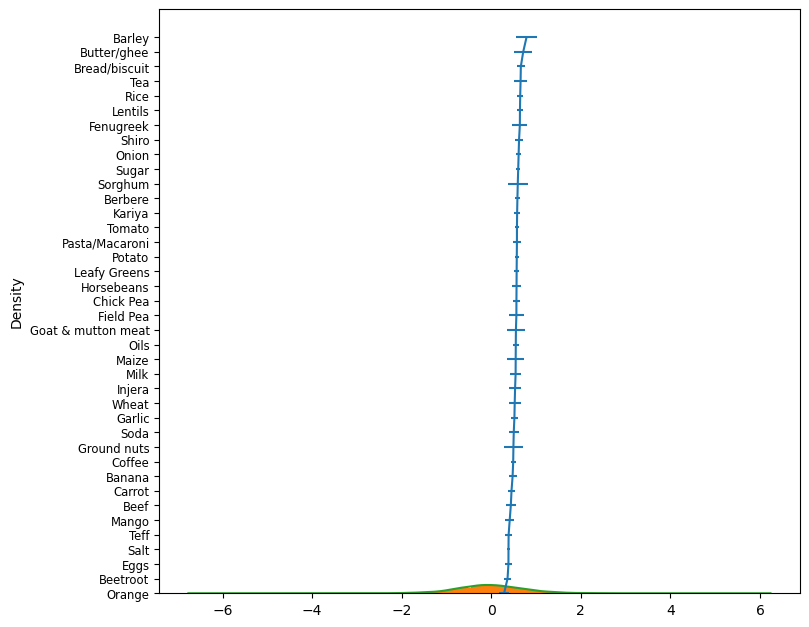

In [7]:
r = rgsn.Regression(y=y,d=d)
ax = r.graph_beta()
r.get_beta()
r.get_gamma()
ax = r.get_w().plot.hist(bins=100,density=True)
r.get_w().plot.kde(ax=ax)
r.to_pickle('ethiopia_estimates.rgsn')

### Additional Data



Using the data on household characteristics and (log) expenditures, we can estimate the demand system (`d`,=y=).  This gives us predictions of expenditures on different kinds of foods.  Then if we divide these expenditures by prices, we get predicted quantities of food.

However, here we&rsquo;re interested in nutritional outcomes, so we need a food conversion table:



In [8]:
fct = read_sheets(Ethiopia_Data,sheet='FCT')

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

We also want to establish when nutrition is *adequate* for households with different compositions.  For this, we want data on recommended dietary intakes:



In [9]:
rdi = read_sheets(Ethiopia_Data,sheet='RDI')

rdi = rdi.set_index('n')
rdi.columns.name = 'k'

rdi = rdi.apply(lambda x: pd.to_numeric(x,errors='coerce'))

#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [10]:
# Assumes you've already set this up e.g., in Project 3
r = rgsn.read_pickle('ethiopia_estimates.rgsn')

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [11]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.loc[r.beta.index].mean(axis=1).fillna(1) # Only use prices for goods we can estimate

#### Budgets



Get food budget for all households, then find median budget:



In [12]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [13]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Banana,Barley,Beef,Beetroot,Berbere,Bread/biscuit,Butter/ghee,Carrot,Chick Pea,Coffee,...,Rice,Salt,Shiro,Soda,Sorghum,Sugar,Tea,Teff,Tomato,Wheat
i,t,m,,,,,,,,,,,,,,,,,,,,,
010101088800910017,2018-19,Tigray,0.413448,0.873332,0.629931,0.394955,0.186324,0.362870,0.101935,0.332159,0.677600,0.161405,...,0.656097,0.114999,0.410137,0.403431,3.539112,0.321945,0.150474,4.458301,0.502392,2.924948
010101088800910026,2018-19,Tigray,0.513472,0.799811,0.617154,0.370081,0.162010,0.309491,0.101811,0.256859,0.563979,0.153774,...,0.557511,0.100283,0.403814,0.419849,3.966817,0.290751,0.149741,4.397499,0.451142,2.399674
010101088800910029,2018-19,Tigray,0.545041,0.715252,0.682824,0.387508,0.227877,0.370559,0.175109,0.285523,0.576399,0.188726,...,0.531924,0.098739,0.438953,0.497123,3.787831,0.310494,0.195002,3.436222,0.570477,2.085938
010101088800910046,2018-19,Tigray,0.420057,0.566860,0.496171,0.376181,0.182603,0.358792,0.123134,0.253919,0.600295,0.167946,...,0.681969,0.109439,0.377164,0.386025,2.931917,0.381308,0.173901,4.099479,0.487625,3.417713
010101088800910054,2018-19,Tigray,0.539680,0.799779,0.648509,0.394967,0.223485,0.399198,0.193097,0.283582,0.676502,0.193055,...,0.713396,0.112441,0.443617,0.477688,4.135037,0.388627,0.218546,4.067916,0.617499,2.716165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5.0511E+16,2018-19,Somali,2.205409,3.409047,1.082480,0.837192,0.227766,1.718588,0.232490,1.252165,0.916014,0.345938,...,4.307922,0.315860,1.046515,1.739275,3.821920,2.422879,0.525154,4.201316,1.876677,3.838458
6.0104E+16,2018-19,Benishangul-Gumuz,0.606798,0.768066,0.820877,0.620629,0.348293,0.786185,0.332224,0.720905,0.858413,0.333594,...,0.976222,0.219212,0.652867,0.805118,4.570689,0.759980,0.281383,5.611119,1.139309,2.070048
7.0211E+16,2018-19,SNNP,0.444011,0.828702,0.690302,0.434735,0.267096,0.634788,0.393360,0.537671,0.472582,0.235554,...,0.501562,0.169056,0.464483,0.881795,1.019647,0.373515,0.264338,2.737195,0.813911,1.625396


Finally, define a function to change a single price in the vector $p$:



In [14]:
def my_prices(j,p0,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed at p.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



In [15]:
%matplotlib inline

Text(0.5, 0, 'Quantities of Milk Demanded')

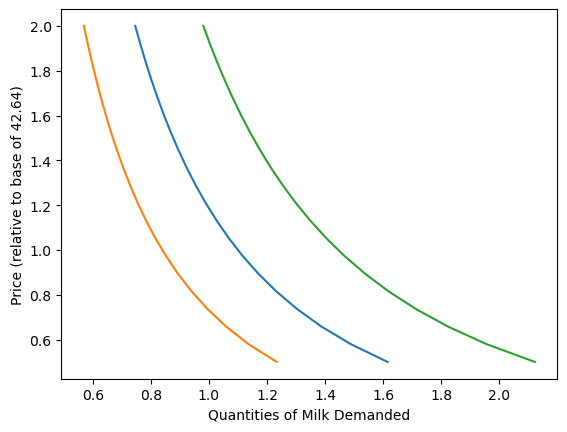

In [16]:
import matplotlib.pyplot as plt

use = 'Milk'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Matoke for household at median budget
plt.plot([r.demands(xref,my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Matoke for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Matoke for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(use,pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



Text(0.5, 1.0, 'Engel Curves')

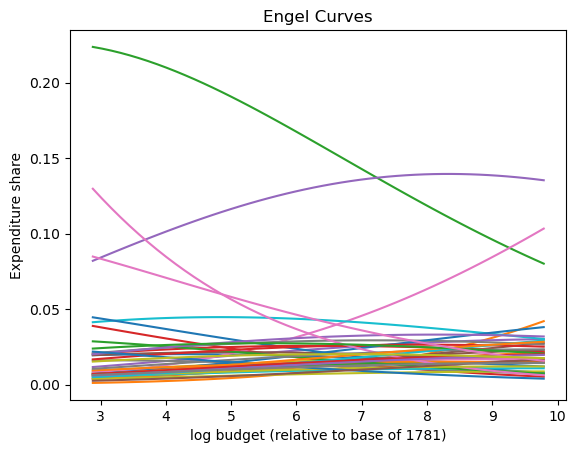

In [17]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [18]:
fct

n,Energy,Protein,Vitamin A,Vitamin D,Vitamin E,Vitamin C,Vitamin B-6,Vitamin B-12,Calcium,Magnesium,...,Zinc,Fiber,Folate,Carbohydrate,Niacin,Phosphorus,Potassium,Riboflavin,Thiamin,Vitamin K
j,,,,,,,,,,,,,,,,,,,,,
Avocado,1601.338432,20.00000,70,0,20.7,100,2.570,0,120.00,290.0,...,6.400,67.00,810.0,85.30000,17.38,520.0,4850.0,1.300,0.6700,210.0
Banana,890.000000,11.00000,30,0,1.0,87,4.000,0,50.00,270.0,...,2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Barley,3490.000000,123.00000,0,0,10.0,0,2.000,0,260.00,920.0,...,20.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beef,3230.000000,249.00000,0,0,0.0,0,3.000,19,40.00,230.0,...,41.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beer,410.000000,3.00000,0,0,0.0,0,1.000,0,50.00,60.0,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Beetroot,430.210325,16.10000,20,0,0.4,49,0.670,0,160.00,230.0,...,3.500,28.00,1090.0,95.60000,3.34,400.0,3250.0,0.400,0.3100,2.0
Berbere,74.869981,8.95625,0,0,0.0,1417,3.027,0,63.61,109.8,...,2.023,11.58,473.2,66.53175,10.24,265.9,2127.0,1.422,0.5494,0.0
Boye/Yam,970.000000,21.00000,0,0,50.0,120,2.000,0,80.00,260.0,...,5.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bread/biscuit,2740.000000,80.00000,0,0,0.0,0,0.000,0,100.00,270.0,...,9.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [19]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Banana', 'Barley', 'Beef', 'Beetroot', 'Berbere', 'Bread/biscuit',
       'Butter/ghee', 'Coffee', 'Eggs', 'Fenugreek', 'Garlic',
       'Goat & mutton meat', 'Ground nuts', 'Injera', 'Leafy Greens', 'Maize',
       'Mango', 'Milk', 'Oils', 'Onion', 'Orange', 'Pasta/Macaroni', 'Potato',
       'Rice', 'Salt', 'Soda', 'Sorghum', 'Sugar', 'Tea', 'Teff'],
      dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [20]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i,010101088800910017,010101088800910026,010101088800910029,010101088800910046,010101088800910054,010101088800910062,010101088800910070,010101088800910082,010101088800910093,010102088801010034,...,3.0714E+16,4.1602E+16,4.2828E+16,4.303E+16,5.01031E+16,5.0511E+16,6.0104E+16,7.0211E+16,7.06101E+16,7.10031E+16
t,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,...,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19,2018-19
m,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,Tigray,...,Amhara,Oromia,Oromia,Oromia,Somali,Somali,Benishangul-Gumuz,SNNP,SNNP,SNNP
n,,,,,,,,,,,,,,,,,,,,,
Energy,53380.050977,53235.605392,50429.366970,48685.005319,56341.348321,57372.827743,65603.438217,62248.337280,55325.723046,86878.703613,...,97562.203018,82541.667922,79028.751053,61981.250286,151736.401845,126496.715165,77983.912865,45576.231485,27901.506279,25516.807031
Protein,1736.118281,1722.262115,1610.749420,1570.032496,1768.526338,1949.468521,2210.605769,2019.100747,1906.817566,2787.579815,...,3011.872218,2669.108125,2633.488564,2052.574553,4558.406602,3974.407603,2432.796133,1563.125313,1019.467722,895.658028
Vitamin A,15909.412372,16396.838544,16058.049863,14618.484919,16512.142427,17006.033646,21617.603242,18803.141734,16879.185629,26744.917524,...,27993.394248,21824.279763,22518.621806,18004.982934,70760.489323,66080.713643,25202.554574,25230.587212,13654.831369,12749.045316
Vitamin D,91.351447,90.875650,79.005142,82.119426,81.625516,92.803408,108.313681,92.213723,86.346191,138.177989,...,163.531270,106.812630,118.982946,90.318438,483.779721,414.093006,116.979149,117.597956,88.760439,66.720859
Vitamin E,106.156560,103.536199,111.530046,100.126589,116.467392,117.089583,145.220497,128.756248,117.183547,187.690439,...,244.275972,225.883200,202.042821,178.185166,405.523460,393.619226,192.256175,153.941307,73.723176,78.535618
Vitamin C,1686.106852,1634.627528,1426.365504,1510.154244,1488.866987,1520.325394,2287.733891,1715.183029,1680.477485,2444.654085,...,2545.675674,1704.821791,1778.898641,1423.603975,3309.315861,3269.840236,1660.352397,1926.556384,930.478525,1053.100395
Vitamin B-6,52.145114,51.959802,48.582217,47.453663,53.177158,57.862084,67.712244,61.030525,57.686774,82.212787,...,86.851560,74.302922,73.516794,57.887892,118.342360,109.497405,74.849432,46.985839,27.972875,26.995743


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [21]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

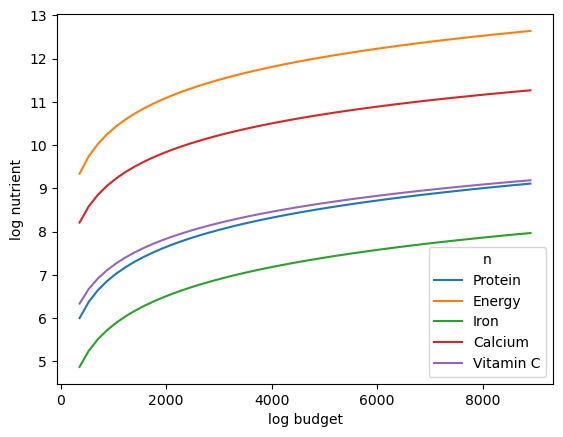

In [22]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



Text(0, 0.5, 'log nutrient')

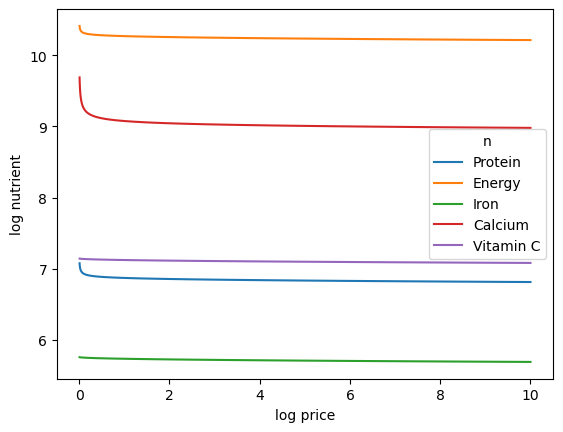

In [23]:
USE_GOOD = 'Milk'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(USE_GOOD,pbar[USE_GOOD]*s)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [24]:
# In first round, averaged over households and villages
dbar = r.d[rdi.columns].mean()

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [25]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi@dbar

hh_rdi

n
Energy           7629.418935
Protein           171.352093
Fiber             106.811865
Folate           1427.377082
Calcium          4482.446160
Carbohydrate      554.995937
Iron               47.710687
Magnesium        1227.683868
Niacin             54.196668
Phosphorus       3346.921983
Potassium       18678.545307
Riboflavin          4.257883
Thiamin             4.131288
Vitamin A        2836.428281
Vitamin B-12        8.564262
Vitamin B-6         4.700223
Vitamin C         261.073751
Vitamin E          53.273872
Vitamin K         343.995327
Zinc               34.263714
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [26]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



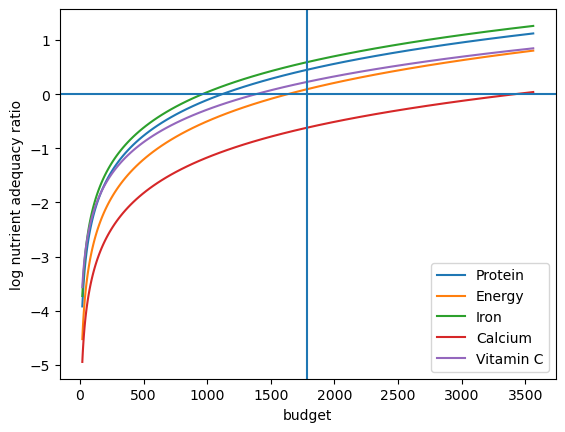

In [27]:
X = np.geomspace(.01*xref,2*xref,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



Text(0.5, 0, 'log nutrient adequacy ratio')

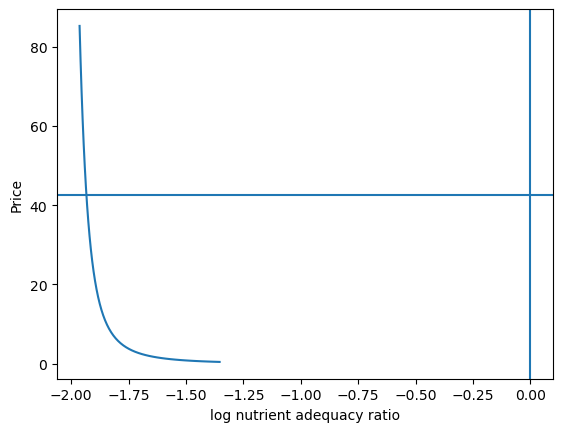

In [28]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(USE_GOOD,pbar[USE_GOOD]*s),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Calcium'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')